In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

# Importing Libraries for Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.base import clone
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import cross_val_score

# For seasonal decomposition and plots
from matplotlib import dates as mdates
import matplotlib.ticker as ticker

# Other useful libraries
import warnings
warnings.filterwarnings('ignore')

In [3]:
movie = pd.read_csv('/kaggle/input/moviedataset/moviesdataset.csv', encoding='ISO-8859-1')
movie.head()

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
0,,NaN,NaN,Drama,NaN,NaN,J.S. Randhawa,Manmauji,Birbal,Rajendra Bhatia
1,#Gadhvi (He thought he was Gandhi),-2019.0,109 min,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
2,#Homecoming,-2021.0,90 min,"Drama, Musical",NaN,NaN,Soumyajit Majumdar,Sayani Gupta,Plabita Borthakur,Roy Angana
3,#Yaaram,-2019.0,110 min,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
4,...And Once Again,-2010.0,105 min,Drama,NaN,NaN,Amol Palekar,Rajat Kapoor,Rituparna Sengupta,Antara Mali


In [4]:
movie.shape

(15509, 10)

In [5]:
movie.info

<bound method DataFrame.info of                                      Name    Year Duration            Genre  \
0                                             NaN      NaN            Drama   
1      #Gadhvi (He thought he was Gandhi) -2019.0  109 min            Drama   
2                             #Homecoming -2021.0   90 min   Drama, Musical   
3                                 #Yaaram -2019.0  110 min  Comedy, Romance   
4                       ...And Once Again -2010.0  105 min            Drama   
...                                   ...     ...      ...              ...   
15504                 Zulm Ko Jala Doonga -1988.0      NaN           Action   
15505                               Zulmi -1999.0  129 min    Action, Drama   
15506                           Zulmi Raj -2005.0      NaN           Action   
15507                       Zulmi Shikari -1988.0      NaN           Action   
15508                        Zulm-O-Sitam -1998.0  130 min    Action, Drama   

       Rating Votes

In [6]:
movie.describe(include='all')

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
count,15509,14981.000000,7240,13632,7919.000000,7920,14984,13892,13125,12365
unique,13838,NaN,182,485,NaN,2034,5938,4718,4891,4820
top,Anjaam,NaN,120 min,Drama,NaN,8,Jayant Desai,Ashok Kumar,Rekha,Pran
freq,7,NaN,240,2780,NaN,227,58,158,83,91
mean,NaN,-1987.012215,NaN,NaN,5.841621,NaN,NaN,NaN,NaN,NaN
std,NaN,25.416689,NaN,NaN,1.381777,NaN,NaN,NaN,NaN,NaN
min,NaN,-2022.000000,NaN,NaN,1.100000,NaN,NaN,NaN,NaN,NaN
25%,NaN,-2009.000000,NaN,NaN,4.900000,NaN,NaN,NaN,NaN,NaN
50%,NaN,-1991.000000,NaN,NaN,6.000000,NaN,NaN,NaN,NaN,NaN
75%,NaN,-1968.000000,NaN,NaN,6.800000,NaN,NaN,NaN,NaN,NaN


In [7]:
movie.isnull().sum()

Name           0
Year         528
Duration    8269
Genre       1877
Rating      7590
Votes       7589
Director     525
Actor 1     1617
Actor 2     2384
Actor 3     3144
dtype: int64

In [8]:
movie.drop_duplicates(subset='Name',inplace=True)
movie.duplicated().value_counts()

False    13838
Name: count, dtype: int64

In [9]:
movie = movie.drop(movie.index[0]).reset_index(drop=True)
movie.head()

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
0,#Gadhvi (He thought he was Gandhi),-2019.0,109 min,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
1,#Homecoming,-2021.0,90 min,"Drama, Musical",NaN,NaN,Soumyajit Majumdar,Sayani Gupta,Plabita Borthakur,Roy Angana
2,#Yaaram,-2019.0,110 min,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
3,...And Once Again,-2010.0,105 min,Drama,NaN,NaN,Amol Palekar,Rajat Kapoor,Rituparna Sengupta,Antara Mali
4,...Aur Pyaar Ho Gaya,-1997.0,147 min,"Comedy, Drama, Musical",4.7,827,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor


In [10]:
movie.isnull().sum().sort_values(ascending=False)/len(movie)

Duration    0.523090
Rating      0.483053
Votes       0.482980
Actor 3     0.202717
Actor 2     0.154080
Genre       0.114909
Actor 1     0.103997
Year        0.035918
Director    0.033606
Name        0.000000
dtype: float64

In [11]:
print("Number of rows:", movie.shape[0])
print("Number of columns:", movie.shape[1])

Number of rows: 13837
Number of columns: 10


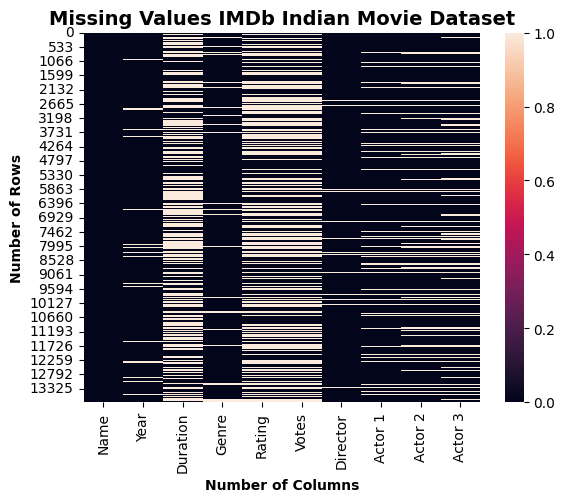

In [12]:
sns.heatmap(movie.isnull())

# Plot Title
plt.title("Missing Values IMDb Indian Movie Dataset",
          fontsize=14,
          fontweight='bold')

# Title for x and y-axis labels with formatting
plt.xlabel("Number of Columns",
           fontweight='bold')
plt.ylabel("Number of Rows",
           fontweight='bold')
plt.show()

In [13]:
movie.drop_duplicates(inplace=True)
movie.shape

(13837, 10)

In [14]:
movie.head()

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
0,#Gadhvi (He thought he was Gandhi),-2019.0,109 min,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
1,#Homecoming,-2021.0,90 min,"Drama, Musical",NaN,NaN,Soumyajit Majumdar,Sayani Gupta,Plabita Borthakur,Roy Angana
2,#Yaaram,-2019.0,110 min,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
3,...And Once Again,-2010.0,105 min,Drama,NaN,NaN,Amol Palekar,Rajat Kapoor,Rituparna Sengupta,Antara Mali
4,...Aur Pyaar Ho Gaya,-1997.0,147 min,"Comedy, Drama, Musical",4.7,827,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor


In [15]:
movie.isnull().sum()

Name           0
Year         497
Duration    7238
Genre       1590
Rating      6684
Votes       6683
Director     465
Actor 1     1439
Actor 2     2132
Actor 3     2805
dtype: int64

In [16]:
missing_count = movie.isnull().sum().sort_values(ascending=False)
missing_percent = (round(movie.isnull().sum()/movie.isnull().count(), 4)*100).sort_values(ascending=False)
missing_data = pd.concat([missing_count, missing_percent],
                       axis=1,
                       keys=['missing_count', 'missing_percent'])
missing_data

,missing_count,missing_percent
Duration,7238,52.31
Rating,6684,48.31
Votes,6683,48.30
Actor 3,2805,20.27
Actor 2,2132,15.41
Genre,1590,11.49
Actor 1,1439,10.40
Year,497,3.59
Director,465,3.36
Name,0,0.00


In [17]:
movie.dropna(subset=['Rating'], inplace=True)
(round(movie.isnull().sum()/movie.isnull().count(), 4)*100).sort_values(ascending=False)


Duration    25.43
Actor 3      3.89
Actor 2      2.66
Actor 1      1.66
Genre        1.20
Director     0.04
Name         0.00
Year         0.00
Rating       0.00
Votes        0.00
dtype: float64

In [18]:
movie.isnull().sum()

Name           0
Year           0
Duration    1819
Genre         86
Rating         0
Votes          0
Director       3
Actor 1      119
Actor 2      190
Actor 3      278
dtype: int64

In [19]:
movie.dropna(subset=['Director', 'Actor 1', 'Actor 2', 'Actor 3', 'Genre'], inplace=True)

(round(movie.isnull().sum()/movie.isnull().count(), 4)*100).sort_values(ascending=False)

Duration    24.44
Name         0.00
Year         0.00
Genre        0.00
Rating       0.00
Votes        0.00
Director     0.00
Actor 1      0.00
Actor 2      0.00
Actor 3      0.00
dtype: float64

In [25]:
movie['Duration'] = movie['Duration'].astype(str)
movie['Duration'] = pd.to_numeric(movie['Duration'].str.replace(' min', ''), errors='coerce')
movie['Duration'].fillna(movie['Duration'].mean(), 
                         inplace=True)

movie.isnull().sum()

Name        0
Year        0
Duration    0
Genre       0
Rating      0
Votes       0
Director    0
Actor 1     0
Actor 2     0
Actor 3     0
dtype: int64

In [26]:
movie.shape

(6813, 10)

In [30]:
print(movie['Votes'].dtype)

# If it's not already a string, convert it to string with commas
movie['Votes'] = movie['Votes'].astype(str)

# Replace commas and convert to int
movie['Votes'] = movie['Votes'].str.replace(',', '').astype(int)

# Check the data type after conversion
print(movie['Votes'].dtype)

object
int64


In [31]:
movie.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6813 entries, 0 to 13836
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      6813 non-null   object 
 1   Year      6813 non-null   float64
 2   Duration  6813 non-null   float64
 3   Genre     6813 non-null   object 
 4   Rating    6813 non-null   float64
 5   Votes     6813 non-null   int64  
 6   Director  6813 non-null   object 
 7   Actor 1   6813 non-null   object 
 8   Actor 2   6813 non-null   object 
 9   Actor 3   6813 non-null   object 
dtypes: float64(3), int64(1), object(6)
memory usage: 585.5+ KB


In [32]:
movie['Year'].unique()

array([-2019., -1997., -2005., -2012., -2014., -2004., -2016., -1991.,
       -2018., -2010., -1958., -2017., -2009., -1993., -2002., -1946.,
       -2008., -1994., -2007., -2013., -2003., -1998., -1979., -1974.,
       -2015., -2006., -1981., -2020., -1985., -2011., -1988., -1995.,
       -1987., -2021., -1999., -1973., -1953., -1986., -1982., -1977.,
       -1968., -1969., -1948., -1970., -1990., -1989., -1947., -2001.,
       -2000., -1971., -1992., -1976., -1984., -1975., -1978., -1980.,
       -1966., -1967., -1972., -1964., -1952., -1959., -1951., -1954.,
       -1962., -1961., -1957., -1965., -1996., -1956., -1933., -1936.,
       -1983., -1955., -1950., -1963., -1949., -1960., -1940., -1945.,
       -1938., -1941., -1942., -1935., -1937., -1944., -1931., -1932.,
       -1943., -1917., -1939., -1934.])

In [33]:
movie[['Rating', 'Duration', 'Votes']].describe()

,Rating,Duration,Votes
count,6813.000000,6813.000000,6813.000000
mean,5.820065,132.816434,2107.025099
std,1.375330,22.224326,12378.151829
min,1.100000,21.000000,5.000000
25%,4.900000,123.000000,18.000000
50%,6.000000,132.816434,64.000000
75%,6.800000,144.000000,500.000000
max,10.000000,321.000000,591417.000000


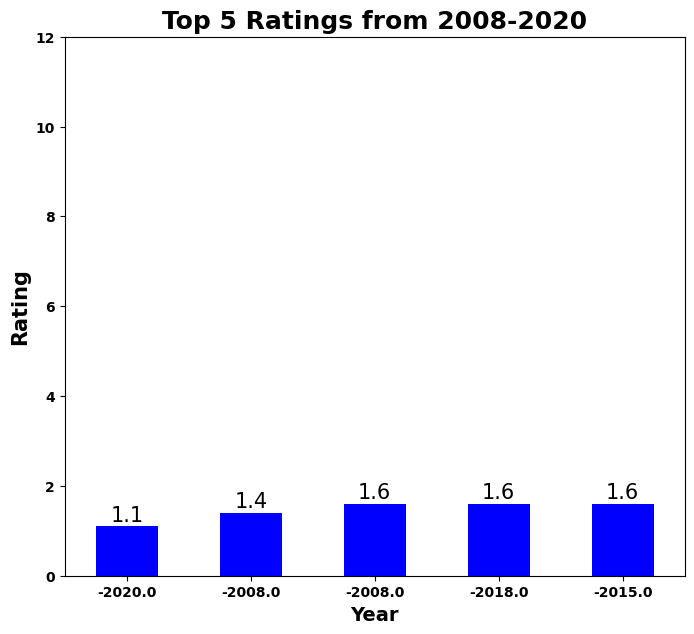

In [34]:

top5_rating = movie[['Year', 'Rating']].sort_values(by = 'Rating',
                                                    ascending = True).head()
bars = top5_rating.plot(kind = 'bar',
                        x = 'Year',
                        y = 'Rating',
                        color = 'blue',
                        legend = None,
                        figsize = (8,7))
plt.xlabel('Year',
           fontsize = 14,
           fontweight = 'bold')
plt.ylabel('Rating',
           fontsize = 15,
           fontweight = 'bold')
plt.title('Top 5 Ratings from 2008-2020',
          fontsize = 18,
          fontweight = 'bold')
plt.xticks(fontweight = 'bold',
           rotation = 0)
plt.yticks(np.arange(0, 13, 2), fontweight='bold')

#Labelling Plot
for bar in bars.patches:
    plt.annotate(format(bar.get_height(), '.1f'),
                 (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                 ha='center',
                 va='center',
                 size=15,
                 xytext=(0, 8),
                 textcoords='offset points')

plt.show()

In [37]:
movie[movie['Votes']>10000]

,Name,Year,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
51,2 States,-2014.0,"Comedy, Drama, Romance",6.9,24034,Abhishek Varman,Arjun Kapoor,Alia Bhatt,Amrita Singh
52,2,-2018.0,"Action, Sci-Fi",6.2,21938,S. Shankar,Rajinikanth,Akshay Kumar,Amy Jackson
73,3 Idiots,-2009.0,"Comedy, Drama",8.4,357889,Rajkumar Hirani,Aamir Khan,Madhavan,Mona Singh
169,A Wednesday,-2008.0,"Action, Crime, Drama",8.1,75118,Neeraj Pandey,Anupam Kher,Naseeruddin Shah,Jimmy Sheirgill
346,Aamir,-2008.0,"Action, Crime, Drama",7.7,10862,Raj Kumar Gupta,Rajeev Khandelwal,Aishwarya,Vasan Bala
...,...,...,...,...,...,...,...,...,...
13430,When Love Calls,-1989.0,"Drama, Musical, Romance",7.3,11486,Sooraj R. Barjatya,Salman Khan,Bhagyashree,Alok Nath
13614,Yeh Jawaani Hai Deewani,-2013.0,"Drama, Musical, Romance",7.1,39863,Ayan Mukherjee,Ranbir Kapoor,Deepika Padukone,Aditya Roy Kapoor
13666,Yes Boss,-1997.0,"Comedy, Drama, Musical",6.8,12714,Aziz Mirza,Shah Rukh Khan,Juhi Chawla,Aditya Pancholi
13770,Zero,-2018.0,"Comedy, Drama, Romance",5.4,24784,Aanand L. Rai,Shah Rukh Khan,Anushka Sharma,Katrina Kaif


In [44]:
movie.shape

(6813, 9)

In [45]:
movie_update = movie.drop(['Name'], axis=1)

In [46]:
movie_update.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6813 entries, 0 to 13836
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Year      6813 non-null   float64
 1   Genre     6813 non-null   object 
 2   Rating    6813 non-null   float64
 3   Votes     6813 non-null   int64  
 4   Director  6813 non-null   object 
 5   Actor 1   6813 non-null   object 
 6   Actor 2   6813 non-null   object 
 7   Actor 3   6813 non-null   object 
dtypes: float64(2), int64(1), object(5)
memory usage: 479.0+ KB


In [47]:
X = movie_update.drop('Rating', axis=1)
Y = movie_update['Rating']

X.head()

,Year,Genre,Votes,Director,Actor 1,Actor 2,Actor 3
0,-2019.0,Drama,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
2,-2019.0,"Comedy, Romance",35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
4,-1997.0,"Comedy, Drama, Musical",827,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor
5,-2005.0,"Drama, Romance, War",1086,Shoojit Sircar,Jimmy Sheirgill,Minissha Lamba,Yashpal Sharma
7,-2012.0,"Horror, Mystery, Thriller",326,Allyson Patel,Yash Dave,Muntazir Ahmad,Kiran Bhatia


In [48]:
actor1_encoding_map = movie_update.groupby('Actor 1').agg({'Rating': 'mean'}).to_dict()
actor2_encoding_map = movie_update.groupby('Actor 2').agg({'Rating': 'mean'}).to_dict()
actor3_encoding_map = movie_update.groupby('Actor 3').agg({'Rating': 'mean'}).to_dict()
director_encoding_map = movie_update.groupby('Director').agg({'Rating': 'mean'}).to_dict()
genre_encoding_map = movie_update.groupby('Genre').agg({'Rating': 'mean'}).to_dict()

In [49]:
movie_update['actor1_encoded'] = round(movie_update['Actor 1'].map(actor1_encoding_map['Rating']),1)
movie_update['actor2_encoded'] = round(movie_update['Actor 2'].map(actor2_encoding_map['Rating']),1)
movie_update['actor3_encoded'] = round(movie_update['Actor 3'].map(actor3_encoding_map['Rating']),1)
movie_update['director_encoded'] = round(movie_update['Director'].map(director_encoding_map['Rating']),1)
movie_update['genre_encoded'] = round(movie_update['Genre'].map(genre_encoding_map['Rating']),1)

In [50]:
movie_update.drop(['Actor 1', 'Actor 2', 'Actor 3', 'Director', 'Genre'], axis=1, inplace=True)
movie_update.head()

,Year,Rating,Votes,actor1_encoded,actor2_encoded,actor3_encoded,director_encoded,genre_encoded
0,-2019.0,7.0,8,6.8,7.0,7.0,7.0,6.4
2,-2019.0,4.4,35,5.4,4.4,4.4,4.4,5.7
4,-1997.0,4.7,827,4.9,5.8,5.9,5.3,6.2
5,-2005.0,7.4,1086,5.2,6.0,6.5,7.5,7.4
7,-2012.0,5.6,326,5.6,5.9,5.6,5.6,5.5


In [51]:
X= movie_update[['Year', 'Votes', 'genre_encoded', 'director_encoded', 'actor1_encoded', 'actor2_encoded', 'actor3_encoded']]
y= movie_update['Rating']

In [52]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred= lr.predict(X_test)

rf = RandomForestRegressor()
rf.fit(X_train, y_train)
rf_pred= rf.predict(X_test)

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Example dataset (X, y) - replace with your actual data
X = [[1], [2], [3], [4], [5]]  # Feature data
y = [1, 2, 3, 4, 5]            # Target data

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test data
lr_pred = model.predict(X_test)

# Print the evaluation metrics
print('Mean Squared Error:', mean_squared_error(y_test, lr_pred))
print('Mean Absolute Error:', mean_absolute_error(y_test, lr_pred))
print('R2 Score:', r2_score(y_test, lr_pred))
print('This is the result by using Linear Regression')


Mean Squared Error: 0.0
Mean Absolute Error: 0.0
R2 Score: nan
This is the result by using Linear Regression
